# MVP Machine Learning & Analytics
Nome: Carlos Leonardo Souza Cardoso

Matrícula: 4052025000555

Dataset: [Metereological Data - Brazil (2018-2024) - INMET](https://www.kaggle.com/datasets/gnomows/dados-metereologicos-2018-2024-inmet/data)

## Proposta do trabalho
- O problema abordado neste Jupyter Notebook foi a previsão de precipitação horária na região Sudeste do Brasil utilizando dados meteorológicos históricos do INMET (2018-2024). 
- O objetivo foi construir modelos preditivos capazes de estimar a quantidade de chuva com base em variáveis como temperatura, pressão, umidade, radiação, entre outras.
- Para isso, foi realizado um extenso tratamento dos dados, incluindo padronização de colunas, conversão de formatos, remoção de nulos e outliers, além da seleção de registros relevantes.
Foram testados diferentes algoritmos de regressão (RandomForest, XGBoost e ConvLSTM) e avaliados quanto à capacidade de generalização nos dados mais recentes (2024).
- O projeto também discutiu desafios como desbalanceamento dos dados, limitações computacionais e a importância de variáveis ambientais adicionais para melhorar a precisão das previsões meteorológicas.

## Análise dos dados
 Primeiro passo vamos fazer o Download dos dados e descompactar em um diretório para os datasets

In [ ]:
!curl -L -o dados-metereologicos-2018-2024-inmet.zip\
  https://www.kaggle.com/api/v1/datasets/download/gnomows/dados-metereologicos-2018-2024-inmet

In [ ]:
!unzip -o dados-metereologicos-2018-2024-inmet.zip -d dados

In [13]:
!ls dados/

2018.csv  2019.csv  2020.csv  2021.csv	2022.csv  2023.csv  2024.csv


Inslatar bibliotecas necessárias caso não estejam instaladas

In [ ]:
# Install necessary libraries - Check your environment before running this command
!pip install polars scikit-learn xgboost lightgbm catboost tensorflow keras Unidecode folium tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 105.6 MB/s eta 0:00:00m eta 0:00:010:01


Carregar as bibliotecas necessárias

In [ ]:

import pprint
from unidecode import unidecode
import polars as pl
import pandas as pd
import os
import json
import glob
import unicodedata
import csv
import re
import folium
import gc
from difflib import get_close_matches
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense, Reshape
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Como são vários datasets que indicam o ano de cada coleta, vamos checar primeiro se os cabeçalhos possuem o mesmo nome, pois isso pode gerar problema no caso da concatenação dos dados quando forem necessários.

In [2]:
arquivos = glob.glob("dados/*.csv")
def ler_cabeçalho(arquivo):
    with open(arquivo, "r", encoding="utf-8") as f:
        return f.readline().strip()

for arquivo in arquivos:
    print(f"{arquivo}: {ler_cabeçalho(arquivo)}")

dados/2019.csv: Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",REGIAO,UF,ESTACAO,CODIGO (WMO),LATITUDE,LONGITUDE,ALTITUDE,DATA DE FUNDAC?O
dados/2023.csv: Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN

Assim consguimos confirmar que de fato os datasets possuem colunas com nomes diferentes em alguns arquivos. Então vamos criar um mapa com os nomes que queremos adotar e renomear as colunas.

A saída que tenho acima é o que espero, então o arquivo salvo com o que quero está correto. Estou fazendo esse processo de staging salvando em arquivos para que caso necessário reesecutar alguns processos não tenha que executar todas as células do notebook novamente.

In [ ]:

colunas_padrao = [
    "data","hora_utc","precipitacao_total_horario_mm",
    "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb",
    "pressao_atmosferica_max_na_hora_ant_aut_mb",
    "pressao_atmosferica_min_na_hora_ant_aut_mb",
    "radiacao_global_kj_m2",
    "temperatura_do_ar_bulbo_seco_horaria_degc",
    "temperatura_do_ponto_de_orvalho_degc",
    "temperatura_maxima_na_hora_ant_aut_degc",
    "temperatura_minima_na_hora_ant_aut_degc",
    "temperatura_orvalho_max_na_hora_ant_aut_degc",
    "temperatura_orvalho_min_na_hora_ant_aut_degc",
    "umidade_rel_max_na_hora_ant_aut",
    "umidade_rel_min_na_hora_ant_aut",
    "umidade_relativa_do_ar_horaria",
    "vento_direcao_horaria_gr_deg_gr",
    "vento_rajada_maxima_m_s",
    "vento_velocidade_horaria_m_s",
    "regiao","uf","estacao","codigo_wmo",
    "latitude","longitude","altitude",
    "data_de_fundacao"
]

# --- normalização (remove acentos, pontuação -> snake_case) ---
def normalize_name(s):
    s = str(s)
    s = s.strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

# mapa de normalização das canônicas
canon_norm = { normalize_name(c): c for c in colunas_padrao }
canon_norm_list = list(canon_norm.keys())

# pasta com CSVs (ajuste conforme necessário)
pasta = "dados"
arquivos = glob.glob(f"{pasta}/*.csv")

# coleta todos os cabeçalhos originais
todas_cols = set()
for arq in arquivos:
    try:
        import pandas as pd
        hdr = pd.read_csv(arq, nrows=0).columns.tolist()
        hdr = [h.strip() for h in hdr]
        todas_cols.update(hdr)
    except Exception as e:
        print("Erro ao ler cabeçalho de", arq, "->", e)

# cria sugestões
mapa_sugerido = {}
relatorio = []

for orig in sorted(todas_cols):
    norm = normalize_name(orig)
    mapped = None
    method = None
    score = 0.0

    # 1) match exato na forma normalizada
    if norm in canon_norm:
        mapped = canon_norm[norm]
        method = "exact_norm"

    # 2) tentativa por close match (difflib) na normalizada
    else:
        matches = get_close_matches(norm, canon_norm_list, n=1, cutoff=0.7)
        if matches:
            mapped = canon_norm[matches[0]]
            method = "fuzzy_norm"
            # compute a naive score (ratio of common prefix length) — for info only
            # (difflib.get_close_matches já fez o trabalho)
            score = 1.0

    # 3) fallback: se não encontrado, sugerir manter normalizado como fallback
    if not mapped:
        mapped = norm  # sugerir o nome normalizado (você pode revisar)
        method = "normalized_fallback"

    mapa_sugerido[orig] = mapped
    relatorio.append({"original": orig, "normalized": norm, "mapped_to": mapped, "method": method, "score": score})

# salvar JSON sugerido e relatório CSV
with open("mapa_variacoes_sugerido.json", "w", encoding="utf-8") as f:
    json.dump(mapa_sugerido, f, indent=2, ensure_ascii=False)


with open("mapa_variacoes_relatorio.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["original","normalized","mapped_to","method","score"])
    writer.writeheader()
    writer.writerows(relatorio)

print("Pronto: 'mapa_variacoes_sugerido.json' e 'mapa_variacoes_relatorio.csv' gerados.")
print("Revise o JSON antes de aplicar (verifique mapeamentos 'fuzzy' e 'normalized_fallback').")


Pronto: 'mapa_variacoes_sugerido.json' e 'mapa_variacoes_relatorio.csv' gerados.
Revise o JSON antes de aplicar (verifique mapeamentos 'fuzzy' e 'normalized_fallback').


Vamos checar o que foi salvo para aplicar nos datasets para correção é o que esperamos.

In [6]:
pprint.pprint(mapa_sugerido)
pprint.pprint(relatorio)


{'ALTITUDE': 'altitude',
 'CODIGO (WMO)': 'codigo_wmo',
 'DATA DE FUNDAC?O': 'data_de_fundacao',
 'DATA DE FUNDACAO': 'data_de_fundacao',
 'DATA DE FUNDAÇÃO (YYYY-MM-DD)': 'data_de_fundacao',
 'Data': 'data',
 'ESTACAO': 'estacao',
 'HORA (UTC)': 'hora_utc',
 'Hora UTC': 'hora_utc',
 'LATITUDE': 'latitude',
 'LONGITUDE': 'longitude',
 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitacao_total_horario_mm',
 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb',
 'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'pressao_atmosferica_max_na_hora_ant_aut_mb',
 'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'pressao_atmosferica_min_na_hora_ant_aut_mb',
 'RADIACAO GLOBAL (KJ/m²)': 'radiacao_global_kj_m2',
 'RADIACAO GLOBAL (Kj/m²)': 'radiacao_global_kj_m2',
 'REGIAO': 'regiao',
 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temperatura_do_ar_bulbo_seco_horaria_degc',
 'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'temperatura_do_ponto_d

Ótimo. Agora temos um mapeamento das colnas com nomes sem caracteres especiais e sem espaços. Isso vai facilitar trabalhar o dataset e também para os treinamentos e teste dos modelos. Esse passo é muito importante para que não tenhamos surpresas em etapas futuras.

In [8]:
for arquivo in arquivos:
    print(f"\nArquivo: {arquivo}")
    df = pl.read_csv(arquivo, n_rows=100, ignore_errors=True)
    pprint.pprint(df.schema)


Arquivo: dados/2019.csv
Schema([('Data', String),
        ('Hora UTC', String),
        ('PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', String),
        ('PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', String),
        ('PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', String),
        ('PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', String),
        ('RADIACAO GLOBAL (KJ/m²)', String),
        ('TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', String),
        ('TEMPERATURA DO PONTO DE ORVALHO (°C)', String),
        ('TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', String),
        ('TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', String),
        ('TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)', String),
        ('TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)', String),
        ('UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)', Float64),
        ('UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', Float64),
        ('UMIDADE RELATIVA DO AR, HORARIA (%)', Float64),
        ('VENTO, DIREÇÃO HORAR

Então vemos que vários dados em colunas que espero valores numéricos estão sendo reconhecidos como strings, que também pode ser um problema no futuro. Então devemos tratar isso, mas antes preciso saber como estão esses dados para saber como converter.

In [17]:
with open("dados/2018.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

print("\n--- Próximo arquivo ---\n")

with open("dados/2019.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

print("\n--- Próximo arquivo ---\n")

with open("dados/2020.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

print("\n--- Próximo arquivo ---\n")

with open("dados/2021.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

print("\n--- Próximo arquivo ---\n")

with open("dados/2022.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

print("\n--- Próximo arquivo ---\n")

with open("dados/2023.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

print("\n--- Próximo arquivo ---\n")

with open("dados/2024.csv", "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

Data,HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",REGIAO,UF,ESTACAO,CODIGO (WMO),LATITUDE,LONGITUDE,ALTITUDE,DATA DE FUNDAÇÃO (YYYY-MM-DD)
2018-01-01,00:00,0,"960,8","960,8","960,1",-9999,"23,4","22,8","24,1","23,4","22,8",21,96,83,96,111,"3,4",",3",SE,SP,PRESIDENTE PRUDENTE,A707,-22,-51,435,2003-02-04
2018-01-01,01:00,0,"960,8","

Os dados estão contidos em "" e com os valores float separando a casa decimal por ',' . Parece que é um padrão que pode ter sido gerado dos dados direto dos sensores ou tratado e salvo dessa forma. Então sabemos agora como estão e o que precisamos para a conversão.

In [ ]:
pasta = "dados" # diretório com os CSVs originais
saida_pasta = "padronizados" # diretório para salvar os CSVs padronizados
os.makedirs(saida_pasta, exist_ok=True)

### Explicação das funções criadas na célula abaixo

Nesta célula, são definidas funções auxiliares para o processamento dos nossos arquivos CSV. O objetivo é detectar automaticamente o formato dos arquivos e preparar os dados para padronização e análise.

#### Funções definidas:

- **sample_text(path, nbytes=20000):**
    - Lê os primeiros `nbytes` de um arquivo texto (CSV) para amostragem, útil para detectar padrões de separadores e formatos numéricos.

- **detect_sep(sample):**
    - Detecta automaticamente o separador de colunas do CSV (vírgula, ponto e vírgula, tabulação, pipe) usando o `csv.Sniffer` ou, em caso de falha, uma heurística baseada na contagem de caracteres na primeira linha.

- **detect_decimal_and_thousands(sample):**
    - Analisa a amostra do arquivo para identificar qual caractere é usado como separador decimal (vírgula ou ponto) e qual como separador de milhares, usando expressões regulares.

- **coerce_numeric_series(s, decimal_hint=None, thousands_hint=None):**
    - Converte uma série de texto para valores numéricos, aplicando heurísticas para remover espaços, aspas, separadores de milhares e ajustar o separador decimal. Usa o pandas para converter para tipo numérico, tratando valores ausentes.

Essas funções permitem ler arquivos CSV com diferentes formatos e garantir que os dados sejam corretamente interpretados e convertidos para análise posterior.

In [3]:

# carrega mapa (como no seu código)
with open("mapa_variacoes_sugerido.json", "r", encoding="utf-8") as f:
    mapa_variacoes = json.load(f)
mapa_variacoes_clean = {k.strip(): v for k, v in mapa_variacoes.items()}

# ---------- detectores ----------
def sample_text(path, nbytes=20000):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read(nbytes)

def detect_sep(sample):
    # tenta csv.Sniffer primeiro (pode falhar)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[',', ';', '\t', '|'])
        return dialect.delimiter
    except Exception:
        # fallback heurístico: conta na primeira linha
        first_line = sample.splitlines()[0] if sample else ""
        counts = {',': first_line.count(','), ';': first_line.count(';'), '\t': first_line.count('\t'), '|': first_line.count('|')}
        sep = max(counts, key=counts.get)
        return sep if counts[sep] > 0 else ','

def detect_decimal_and_thousands(sample):
    comma_decimal = len(re.findall(r'\d+,\d+', sample))
    dot_decimal = len(re.findall(r'\d+\.\d+', sample))
    thousands_dot = len(re.findall(r'\d{1,3}\.\d{3}(?:[.,]\d+)?', sample))
    thousands_comma = len(re.findall(r'\d{1,3}\,\d{3}(?:[.,]\d+)?', sample))

    # heurística simples:
    if comma_decimal > dot_decimal:
        decimal = ','
        thousands = '.' if thousands_dot > 0 else None
    elif dot_decimal > comma_decimal:
        decimal = '.'
        thousands = ',' if thousands_comma > 0 else None
    else:
        decimal = None
        thousands = None
    return decimal, thousands

# converte series texto -> numeric com heurísticas
def coerce_numeric_series(s, decimal_hint=None, thousands_hint=None):
    s = s.astype(str).str.strip()
    s = s.replace({'': None, 'nan': None, 'NaN': None, 'None': None})

    # se não tem nenhum valor útil
    if s.dropna().empty:
        return pd.Series([np.nan] * len(s), index=s.index)

    tmp = s.copy()

    # remover espaços e NBSP
    tmp = tmp.str.replace(r'[ \u00A0]', '', regex=True)

    # remover quotes residuais
    tmp = tmp.str.replace(r'^["\']|["\']$', '', regex=True)

    # remover milhares (se informado)
    if thousands_hint:
        tmp = tmp.str.replace(re.escape(thousands_hint), '', regex=True)
    else:
        # heurística: se tiver padrão 1.234,56 detectamos como milhares '.' e decimal ','
        if tmp.str.contains(r'\d+\.\d{3},').any():
            tmp = tmp.str.replace('.', '', regex=True)

    # unificar decimal para ponto
    if decimal_hint == ',' or (decimal_hint is None and tmp.str.contains(',').any() and not tmp.str.contains(r'\.\d+$').any()):
        tmp = tmp.str.replace(',', '.', regex=False)

    # ainda pode ter outros chars -> tenta converter
    return pd.to_numeric(tmp, errors='coerce')

# ---------- processamento de cada arquivo ----------
arquivos = glob.glob(os.path.join(pasta, "*.csv"))

Agora vamos executar as transformações nos arquivos originais e gerar um diretório com os datasets convertidos, garantindo os nomes das colunas padronizados e os valores float em dados que serão relevantes para o treinamento.

In [4]:
for arq in arquivos:
    fname = os.path.basename(arq)
    print("Processando:", fname)

    sample = sample_text(arq)
    sep = detect_sep(sample)
    decimal, thousands = detect_decimal_and_thousands(sample)

    read_base = dict(sep=sep, encoding="utf-8", low_memory=False)

    # tenta leitura "inteligente" usando decimal/thousands quando disponível
    read_kwargs = read_base.copy()
    if decimal:
        read_kwargs["decimal"] = decimal
    if thousands:
        read_kwargs["thousands"] = thousands

    try:
        df = pd.read_csv(arq, **read_kwargs)
    except Exception as e:
        # fallback: ler tudo como string e tratar depois
        print("  Leitura com parse direto falhou:", e)
        print("  Lendo como strings (fallback)...")
        read_kwargs = read_base.copy()
        read_kwargs["dtype"] = str
        df = pd.read_csv(arq, **read_kwargs)

    # limpeza de cabeçalho
    df.rename(columns=lambda c: c.strip() if isinstance(c, str) else c, inplace=True)

    # renomeia com seu mapa (mesma lógica)
    rename_dict = {}
    for col in df.columns:
        key = col
        key_strip = col.strip() if isinstance(col, str) else col
        if key in mapa_variacoes_clean:
            rename_dict[col] = mapa_variacoes_clean[key]
        elif key_strip in mapa_variacoes_clean:
            rename_dict[col] = mapa_variacoes_clean[key_strip]
    if rename_dict:
        df.rename(columns=rename_dict, inplace=True)

    # converte colunas object -> numeric onde fizer sentido
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in obj_cols:
        converted = coerce_numeric_series(df[col], decimal_hint=decimal, thousands_hint=thousands)
        total_nonnull = df[col].notna().sum()
        conv_nonnull = converted.notna().sum()
        # critério: aceitar conversão se uma fração significativa virar número
        frac = conv_nonnull / max(1, total_nonnull)
        if frac > 0.6 and conv_nonnull > 0:   # ajuste de limiar se quiser
            df[col] = converted
            print(f"  Coluna '{col}': convertida -> {conv_nonnull}/{total_nonnull} ({frac:.1%})")
        else:
            # mantém original se conversão ruim
            # porém podemos tentar uma segunda chance com replace simples
            pass

    saida = os.path.join(saida_pasta, fname)
    df.to_csv(saida, index=False, encoding="utf-8")
    print("  -> salvo:", saida)

print("Concluído. Arquivos em:", saida_pasta)

Processando: 2019.csv
  Coluna 'precipitacao_total_horario_mm': convertida -> 4433500/4433500 (100.0%)
  Coluna 'radiacao_global_kj_m2': convertida -> 2648131/2648131 (100.0%)
  Coluna 'umidade_rel_max_na_hora_ant_aut': convertida -> 4483526/4483526 (100.0%)
  Coluna 'umidade_rel_min_na_hora_ant_aut': convertida -> 4479272/4479272 (100.0%)
  Coluna 'umidade_relativa_do_ar_horaria': convertida -> 4484863/4484863 (100.0%)
  Coluna 'vento_direcao_horaria_gr_deg_gr': convertida -> 4464846/4464846 (100.0%)
  Coluna 'vento_rajada_maxima_m_s': convertida -> 4469159/4469159 (100.0%)
  Coluna 'vento_velocidade_horaria_m_s': convertida -> 4473697/4473697 (100.0%)
  Coluna 'latitude': convertida -> 5048136/5083176 (99.3%)
  -> salvo: padronizados/2019.csv
Processando: 2023.csv
  Coluna 'precipitacao_total_horario_mm': convertida -> 3862421/3862421 (100.0%)
  Coluna 'umidade_rel_max_na_hora_ant_aut': convertida -> 4002852/4002852 (100.0%)
  Coluna 'umidade_rel_min_na_hora_ant_aut': convertida -> 4

In [4]:
df_parcial2018_2 = pl.read_csv("padronizados/2018.csv", n_rows=20, ignore_errors=True)
df_parcial2019_2 = pl.read_csv("padronizados/2019.csv", n_rows=20, ignore_errors=True)
df_parcial2020_2 = pl.read_csv("padronizados/2020.csv", n_rows=20, ignore_errors=True)
df_parcial2021_2 = pl.read_csv("padronizados/2021.csv", n_rows=20, ignore_errors=True)
df_parcial2022_2 = pl.read_csv("padronizados/2022.csv", n_rows=20, ignore_errors=True)
df_parcial2023_2 = pl.read_csv("padronizados/2023.csv", n_rows=20, ignore_errors=True)
df_parcial2024_2 = pl.read_csv("padronizados/2024.csv", n_rows=20, ignore_errors=True)

for arquivo in df_parcial2018_2, df_parcial2019_2, df_parcial2020_2, df_parcial2021_2, df_parcial2022_2, df_parcial2023_2, df_parcial2024_2:
    print(f"\nArquivo: {arquivo}")
    pprint.pprint(arquivo.schema)
    pprint.pprint(arquivo.head())



Arquivo: shape: (20, 27)
┌────────────┬──────────┬────────────┬───────────┬───┬──────────┬───────────┬──────────┬───────────┐
│ data       ┆ hora_utc ┆ precipitac ┆ pressao_a ┆ … ┆ latitude ┆ longitude ┆ altitude ┆ data_de_f │
│ ---        ┆ ---      ┆ ao_total_h ┆ tmosferic ┆   ┆ ---      ┆ ---       ┆ ---      ┆ undacao   │
│ str        ┆ str      ┆ orario_mm  ┆ a_ao_nive ┆   ┆ f64      ┆ i64       ┆ f64      ┆ ---       │
│            ┆          ┆ ---        ┆ l_d…      ┆   ┆          ┆           ┆          ┆ str       │
│            ┆          ┆ f64        ┆ ---       ┆   ┆          ┆           ┆          ┆           │
│            ┆          ┆            ┆ f64       ┆   ┆          ┆           ┆          ┆           │
╞════════════╪══════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪══════════╪═══════════╡
│ 2018-01-01 ┆ 00:00    ┆ 0.0        ┆ 960.8     ┆ … ┆ -22.0    ┆ -51       ┆ 435.0    ┆ 2003-02-0 │
│            ┆          ┆            ┆           ┆   ┆          ┆

Agora temos arquivos convertidos e printos para próximas análises. Como são arquivos grandes, qualquer transformação pode consumir muita memória e certas transformações usando pandas podem ser custosas em quantidade de memória utilizada e tempo de execução. Nesse caso estarei usando a biblioteca polars (https://pola.rs/) pois o ambiente que disponho é local com multithread.

In [5]:
!ls -lh padronizados/

total 4,2G
-rw-rw-r-- 1 carlos carlos 742M set 28 10:52 2018.csv
-rw-rw-r-- 1 carlos carlos 697M set 28 10:50 2019.csv
-rw-rw-r-- 1 carlos carlos 658M set 28 10:56 2020.csv
-rw-rw-r-- 1 carlos carlos 589M set 28 10:55 2021.csv
-rw-rw-r-- 1 carlos carlos 603M set 28 10:53 2022.csv
-rw-rw-r-- 1 carlos carlos 655M set 28 10:51 2023.csv
-rw-rw-r-- 1 carlos carlos 324M set 28 10:52 2024.csv


Os processos a seguir vamos fazer em cada dataset de forma separada para não termos problema de consumo de memória em nosso ambiente. Vamos ver valores nulos e faltantes para removermos. Também vamos remover dias que não ocorreram chuva, vamos manter apenas os dias anteriores a chuvas para ver mudanças de comportamento quando as chuvas ocorrem.

In [3]:
df_2018 = pl.read_csv("padronizados/2018.csv", ignore_errors=True)

In [4]:
# Display the first few rows of the combined DataFrame
print(df_2018.head())
print(df_2018.schema)



shape: (5, 27)
┌────────────┬──────────┬────────────┬───────────┬───┬──────────┬───────────┬──────────┬───────────┐
│ data       ┆ hora_utc ┆ precipitac ┆ pressao_a ┆ … ┆ latitude ┆ longitude ┆ altitude ┆ data_de_f │
│ ---        ┆ ---      ┆ ao_total_h ┆ tmosferic ┆   ┆ ---      ┆ ---       ┆ ---      ┆ undacao   │
│ str        ┆ str      ┆ orario_mm  ┆ a_ao_nive ┆   ┆ f64      ┆ i64       ┆ f64      ┆ ---       │
│            ┆          ┆ ---        ┆ l_d…      ┆   ┆          ┆           ┆          ┆ str       │
│            ┆          ┆ f64        ┆ ---       ┆   ┆          ┆           ┆          ┆           │
│            ┆          ┆            ┆ f64       ┆   ┆          ┆           ┆          ┆           │
╞════════════╪══════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪══════════╪═══════════╡
│ 2018-01-01 ┆ 00:00    ┆ 0.0        ┆ 960.8     ┆ … ┆ -22.0    ┆ -51       ┆ 435.0    ┆ 2003-02-0 │
│            ┆          ┆            ┆           ┆   ┆          ┆           

In [5]:
# Check for missing values
print(df_2018.null_count())

shape: (1, 27)
┌──────┬──────────┬──────────────┬─────────────┬───┬──────────┬───────────┬──────────┬─────────────┐
│ data ┆ hora_utc ┆ precipitacao ┆ pressao_atm ┆ … ┆ latitude ┆ longitude ┆ altitude ┆ data_de_fun │
│ ---  ┆ ---      ┆ _total_horar ┆ osferica_ao ┆   ┆ ---      ┆ ---       ┆ ---      ┆ dacao       │
│ u32  ┆ u32      ┆ io_mm        ┆ _nivel_d…   ┆   ┆ u32      ┆ u32       ┆ u32      ┆ ---         │
│      ┆          ┆ ---          ┆ ---         ┆   ┆          ┆           ┆          ┆ u32         │
│      ┆          ┆ u32          ┆ u32         ┆   ┆          ┆           ┆          ┆             │
╞══════╪══════════╪══════════════╪═════════════╪═══╪══════════╪═══════════╪══════════╪═════════════╡
│ 0    ┆ 0        ┆ 0            ┆ 0           ┆ … ┆ 87600    ┆ 0         ┆ 157680   ┆ 0           │
└──────┴──────────┴──────────────┴─────────────┴───┴──────────┴───────────┴──────────┴─────────────┘


In [6]:
#exibir as primeiras linhas do dataset
print(df_2018.head())

shape: (5, 27)
┌────────────┬──────────┬────────────┬───────────┬───┬──────────┬───────────┬──────────┬───────────┐
│ data       ┆ hora_utc ┆ precipitac ┆ pressao_a ┆ … ┆ latitude ┆ longitude ┆ altitude ┆ data_de_f │
│ ---        ┆ ---      ┆ ao_total_h ┆ tmosferic ┆   ┆ ---      ┆ ---       ┆ ---      ┆ undacao   │
│ str        ┆ str      ┆ orario_mm  ┆ a_ao_nive ┆   ┆ f64      ┆ i64       ┆ f64      ┆ ---       │
│            ┆          ┆ ---        ┆ l_d…      ┆   ┆          ┆           ┆          ┆ str       │
│            ┆          ┆ f64        ┆ ---       ┆   ┆          ┆           ┆          ┆           │
│            ┆          ┆            ┆ f64       ┆   ┆          ┆           ┆          ┆           │
╞════════════╪══════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪══════════╪═══════════╡
│ 2018-01-01 ┆ 00:00    ┆ 0.0        ┆ 960.8     ┆ … ┆ -22.0    ┆ -51       ┆ 435.0    ┆ 2003-02-0 │
│            ┆          ┆            ┆           ┆   ┆          ┆           

In [7]:
#exibir informações sobre o dataset
print(df_2018.describe())

shape: (9, 28)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ data      ┆ hora_utc ┆ precipita ┆ … ┆ latitude  ┆ longitude ┆ altitude  ┆ data_de_f │
│ ---       ┆ ---       ┆ ---      ┆ cao_total ┆   ┆ ---       ┆ ---       ┆ ---       ┆ undacao   │
│ str       ┆ str       ┆ str      ┆ _horario_ ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---       │
│           ┆           ┆          ┆ mm        ┆   ┆           ┆           ┆           ┆ str       │
│           ┆           ┆          ┆ ---       ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆          ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 5128416   ┆ 5128416  ┆ 5.128416e ┆ … ┆ 5.040816e ┆ 5.128416e ┆ 4.970736e ┆ 5128416   │
│           ┆           ┆          ┆ 6         ┆   ┆ 6         ┆ 6         ┆

In [8]:
df_2018_clean = df_2018.drop_nulls()
print(df_2018_clean.head())

shape: (5, 27)
┌────────────┬──────────┬────────────┬───────────┬───┬──────────┬───────────┬──────────┬───────────┐
│ data       ┆ hora_utc ┆ precipitac ┆ pressao_a ┆ … ┆ latitude ┆ longitude ┆ altitude ┆ data_de_f │
│ ---        ┆ ---      ┆ ao_total_h ┆ tmosferic ┆   ┆ ---      ┆ ---       ┆ ---      ┆ undacao   │
│ str        ┆ str      ┆ orario_mm  ┆ a_ao_nive ┆   ┆ f64      ┆ i64       ┆ f64      ┆ ---       │
│            ┆          ┆ ---        ┆ l_d…      ┆   ┆          ┆           ┆          ┆ str       │
│            ┆          ┆ f64        ┆ ---       ┆   ┆          ┆           ┆          ┆           │
│            ┆          ┆            ┆ f64       ┆   ┆          ┆           ┆          ┆           │
╞════════════╪══════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪══════════╪═══════════╡
│ 2018-01-01 ┆ 00:00    ┆ 0.0        ┆ 960.8     ┆ … ┆ -22.0    ┆ -51       ┆ 435.0    ┆ 2003-02-0 │
│            ┆          ┆            ┆           ┆   ┆          ┆           

In [9]:
print(df_2018_clean.shape)

(4909416, 27)


In [10]:
print(df_2018_clean.null_count())

shape: (1, 27)
┌──────┬──────────┬──────────────┬─────────────┬───┬──────────┬───────────┬──────────┬─────────────┐
│ data ┆ hora_utc ┆ precipitacao ┆ pressao_atm ┆ … ┆ latitude ┆ longitude ┆ altitude ┆ data_de_fun │
│ ---  ┆ ---      ┆ _total_horar ┆ osferica_ao ┆   ┆ ---      ┆ ---       ┆ ---      ┆ dacao       │
│ u32  ┆ u32      ┆ io_mm        ┆ _nivel_d…   ┆   ┆ u32      ┆ u32       ┆ u32      ┆ ---         │
│      ┆          ┆ ---          ┆ ---         ┆   ┆          ┆           ┆          ┆ u32         │
│      ┆          ┆ u32          ┆ u32         ┆   ┆          ┆           ┆          ┆             │
╞══════╪══════════╪══════════════╪═════════════╪═══╪══════════╪═══════════╪══════════╪═════════════╡
│ 0    ┆ 0        ┆ 0            ┆ 0           ┆ … ┆ 0        ┆ 0         ┆ 0        ┆ 0           │
└──────┴──────────┴──────────────┴─────────────┴───┴──────────┴───────────┴──────────┴─────────────┘


Como o dataset é muito grande e queremos prever dados metereologicos apenas da região sudeste, vamos ver filtrar o dataset para a região e ver quantas estações possuem nessa região.

Mas antes vamos fazer:
- Contagem do total de estações
- Total de registros de 2018
- Contagem de estações do sudeste
- Total de registros de 2018 na região

In [11]:
print(f"Total de registros válidos 2018 {df_2018_clean.shape[0]}")
estados = ["SP", "RJ", "MG", "ES"]
df_sudeste_2018 = df_2018_clean.filter(pl.col("uf").is_in(estados))
print(f"Total de registros válidos 2018 Sudeste {df_sudeste_2018.shape[0]}")
print(f"Total de estações 2018 {df_2018_clean['estacao'].n_unique()}")
print(f"Total de estações 2018 Sudeste {df_sudeste_2018['estacao'].n_unique()}")

Total de registros válidos 2018 4909416
Total de registros válidos 2018 Sudeste 1265880
Total de estações 2018 570
Total de estações 2018 Sudeste 147


In [12]:
print("Memória usada por df_2018_clean:", df_2018_clean.estimated_size("mb"), "MB")
print("Memória usada por df_sudeste_2018:", df_sudeste_2018.estimated_size("mb"), "MB")

Memória usada por df_2018_clean: 952.2242412567139 MB
Memória usada por df_sudeste_2018: 245.78437042236328 MB


Agora vamos criar um mapa para visualizar as estações de medição no Sudeste.

In [13]:
import parsl
from parsl.app.app import python_app
from parsl.config import Config
from parsl.executors.threads import ThreadPoolExecutor

local_threads = Config(
    executors=[
        ThreadPoolExecutor(
            max_threads=16,
            label='local_threads'
        )
    ]
)

# Load Parsl config before using any Parsl apps
parsl.load(local_threads)

In [14]:
# Extrai coordenadas únicas das estações do Sudeste
estacoes = df_sudeste_2018.select(["estacao", "latitude", "longitude"]).unique()

# Cria o mapa centrado na média das coordenadas
media_lat = estacoes["latitude"].mean()
media_lon = estacoes["longitude"].mean()
mapa_estacoes = folium.Map(location=[media_lat, media_lon], zoom_start=5)

# Adiciona marcadores para cada estação
for row in estacoes.iter_rows():
    _, lat, lon = row
    folium.Marker(location=[lat, lon]).add_to(mapa_estacoes)

# Exibe o mapa
mapa_estacoes

Agora que fizemos esse trabalho para o período de 2018, temos que fazer para os demais datasets dos anos de 2019, 2020, 2021, 2022, 2023 e 2024.
Então vamos:
- Criar uma função para remover os nulos de cada dataset
- Filtrar dados para a região do Sudeste

In [15]:
def remover_nulos_filtro_sudeste(df):
    df = df.drop_nulls()
    df = df.filter(pl.col("uf").is_in(estados))
    return df


In [16]:
df_2019 = pl.read_csv("padronizados/2019.csv", ignore_errors=True)
df_2020 = pl.read_csv("padronizados/2020.csv", ignore_errors=True)
df_2021 = pl.read_csv("padronizados/2021.csv", ignore_errors=True)
df_2022 = pl.read_csv("padronizados/2022.csv", ignore_errors=True)
df_2023 = pl.read_csv("padronizados/2023.csv", ignore_errors=True)
df_2024 = pl.read_csv("padronizados/2024.csv", ignore_errors=True)

In [17]:
df_sudeste_2018 =  remover_nulos_filtro_sudeste(df_2018)
df_sudeste_2019 =  remover_nulos_filtro_sudeste(df_2019)
df_sudeste_2020 =  remover_nulos_filtro_sudeste(df_2020)
df_sudeste_2021 =  remover_nulos_filtro_sudeste(df_2021)
df_sudeste_2022 =  remover_nulos_filtro_sudeste(df_2022)
df_sudeste_2023 =  remover_nulos_filtro_sudeste(df_2023)
df_sudeste_2024 =  remover_nulos_filtro_sudeste(df_2024)

In [18]:
print(f"Total de registros do ano 2018 {df_2018.shape[0]}")
print(f"Total de registros do ano 2018 na região Sudeste {df_sudeste_2018.shape[0]}")
print(f"Total de registros do ano 2019 {df_2019.shape[0]}")
print(f"Total de registros do ano 2019 na região Sudeste {df_sudeste_2019.shape[0]}")
print(f"Total de registros do ano 2020 {df_2020.shape[0]}")
print(f"Total de registros do ano 2020 na região Sudeste {df_sudeste_2020.shape[0]}")
print(f"Total de registros do ano 2021 {df_2021.shape[0]}")
print(f"Total de registros do ano 2021 na região Sudeste {df_sudeste_2021.shape[0]}")
print(f"Total de registros do ano 2022 {df_2022.shape[0]}")
print(f"Total de registros do ano 2022 na região Sudeste {df_sudeste_2022.shape[0]}")
print(f"Total de registros do ano 2023 {df_2023.shape[0]}")
print(f"Total de registros do ano 2023 na região Sudeste {df_sudeste_2023.shape[0]}")
print(f"Total de registros do ano 2024 {df_2024.shape[0]}")
print(f"Total de registros do ano 2024 na região Sudeste {df_sudeste_2024.shape[0]}")

Total de registros do ano 2018 5128416
Total de registros do ano 2018 na região Sudeste 1265880
Total de registros do ano 2019 5118216
Total de registros do ano 2019 na região Sudeste 646496
Total de registros do ano 2020 5173776
Total de registros do ano 2020 na região Sudeste 547063
Total de registros do ano 2021 5150880
Total de registros do ano 2021 na região Sudeste 493154
Total de registros do ano 2022 4948920
Total de registros do ano 2022 na região Sudeste 594681
Total de registros do ano 2023 4966920
Total de registros do ano 2023 na região Sudeste 600633
Total de registros do ano 2024 2472288
Total de registros do ano 2024 na região Sudeste 287928


Como não vamos usar mais os dados completos de cada região, podemos remover isso da memória para não ocupar espaço.

In [19]:
del df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024
gc.collect()

20

In [20]:
# Comparar o esquema (schema) de todos os dataframes df_sudeste
schemas = [
    df_sudeste_2018.schema,
    df_sudeste_2019.schema,
    df_sudeste_2020.schema,
    df_sudeste_2021.schema,
    df_sudeste_2022.schema,
    df_sudeste_2023.schema,
    df_sudeste_2024.schema
]

# Verifica se todos os schemas são iguais
schemas_iguais = all(s == schemas[0] for s in schemas[1:])
print("Todos os schemas são iguais?" , schemas_iguais)

# Se quiser ver os schemas:
for i, schema in enumerate(schemas, start=2018):
    print(f"Schema {i}:")
    pprint.pprint(schema)

Todos os schemas são iguais? False
Schema 2018:
Schema([('data', String),
        ('hora_utc', String),
        ('precipitacao_total_horario_mm', Float64),
        ('pressao_atmosferica_ao_nivel_da_estacao_horaria_mb', Float64),
        ('pressao_atmosferica_max_na_hora_ant_aut_mb', Float64),
        ('pressao_atmosferica_min_na_hora_ant_aut_mb', Float64),
        ('radiacao_global_kj_m2', Float64),
        ('temperatura_do_ar_bulbo_seco_horaria_degc', Float64),
        ('temperatura_do_ponto_de_orvalho_degc', Float64),
        ('temperatura_maxima_na_hora_ant_aut_degc', Float64),
        ('temperatura_minima_na_hora_ant_aut_degc', Float64),
        ('temperatura_orvalho_max_na_hora_ant_aut_degc', Float64),
        ('temperatura_orvalho_min_na_hora_ant_aut_degc', Float64),
        ('umidade_rel_max_na_hora_ant_aut', Int64),
        ('umidade_rel_min_na_hora_ant_aut', Int64),
        ('umidade_relativa_do_ar_horaria', Int64),
        ('vento_direcao_horaria_gr_deg_gr', Int64),
        (

Checando novamente com mais cuidado vimos que algumas colunas de 2022 e 2023 ainda estavam fora do padrão float que alteramos previamente. Então valos para conversão e depois concatenar os dados para treinamento dos modelos.

In [21]:
# Padroniza o schema de todos os DataFrames para o schema de df_sudeste_2018
schema_base = df_sudeste_2018.schema

def padroniza_schema(df, schema_ref):
    for col, dtype in schema_ref.items():
        if col in df.columns and df.schema[col] != dtype:
            df = df.with_columns(pl.col(col).cast(dtype).alias(col))
    return df

dfs_treino = [
    padroniza_schema(df_sudeste_2018, schema_base),
    padroniza_schema(df_sudeste_2019, schema_base),
    padroniza_schema(df_sudeste_2020, schema_base),
    padroniza_schema(df_sudeste_2021, schema_base),
    padroniza_schema(df_sudeste_2022, schema_base),
    padroniza_schema(df_sudeste_2023, schema_base)
]

df_treino = pl.concat(dfs_treino)
df_validacao = padroniza_schema(df_sudeste_2024, schema_base)

In [22]:
print(df_treino.schema)
print(df_validacao.schema)

Schema({'data': String, 'hora_utc': String, 'precipitacao_total_horario_mm': Float64, 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb': Float64, 'pressao_atmosferica_max_na_hora_ant_aut_mb': Float64, 'pressao_atmosferica_min_na_hora_ant_aut_mb': Float64, 'radiacao_global_kj_m2': Float64, 'temperatura_do_ar_bulbo_seco_horaria_degc': Float64, 'temperatura_do_ponto_de_orvalho_degc': Float64, 'temperatura_maxima_na_hora_ant_aut_degc': Float64, 'temperatura_minima_na_hora_ant_aut_degc': Float64, 'temperatura_orvalho_max_na_hora_ant_aut_degc': Float64, 'temperatura_orvalho_min_na_hora_ant_aut_degc': Float64, 'umidade_rel_max_na_hora_ant_aut': Int64, 'umidade_rel_min_na_hora_ant_aut': Int64, 'umidade_relativa_do_ar_horaria': Int64, 'vento_direcao_horaria_gr_deg_gr': Int64, 'vento_rajada_maxima_m_s': Float64, 'vento_velocidade_horaria_m_s': Float64, 'regiao': String, 'uf': String, 'estacao': String, 'codigo_wmo': String, 'latitude': Float64, 'longitude': Int64, 'altitude': Float64, 'data_d

In [23]:
chuva = df_treino.filter(pl.col("precipitacao_total_horario_mm") > 1).shape[0]
print(f"df_treino: {chuva} registros com precipitacao_total_horario_mm > 1")
nao_chuva = df_treino.filter(pl.col("precipitacao_total_horario_mm") < 1).shape[0]
print(f"df_treino: {nao_chuva} registros com precipitacao_total_horario_mm < 1")


df_treino: 109713 registros com precipitacao_total_horario_mm > 1
df_treino: 4025242 registros com precipitacao_total_horario_mm < 1


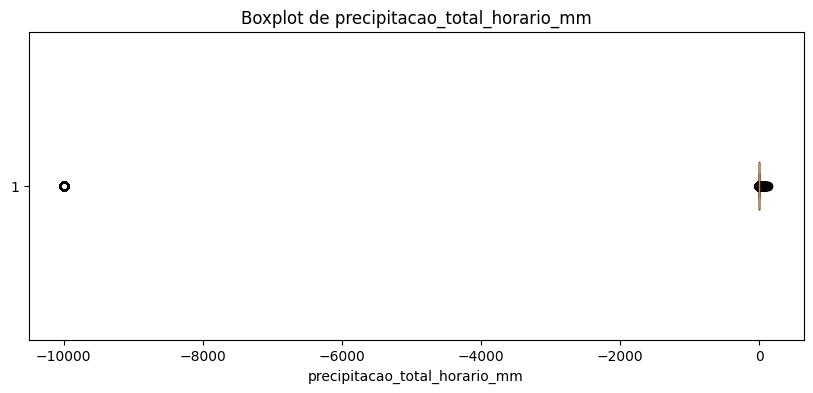

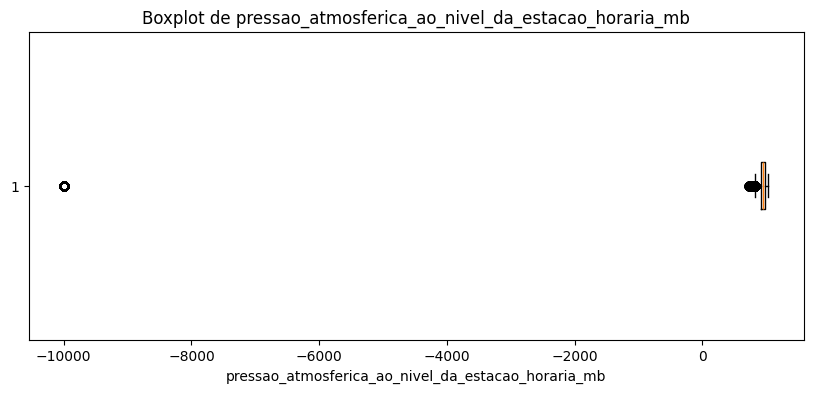

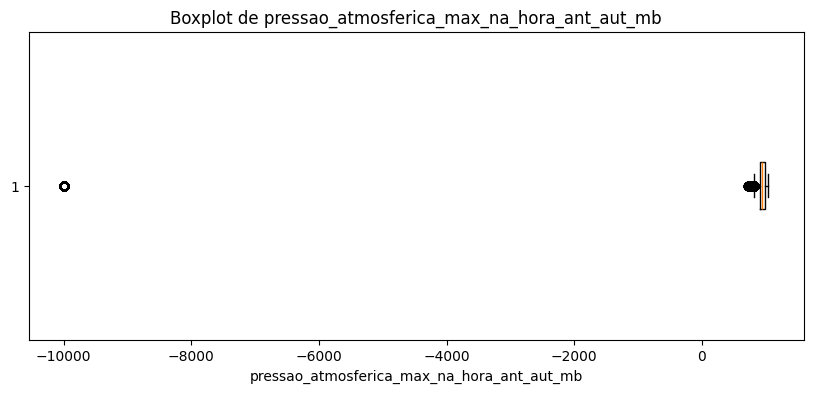

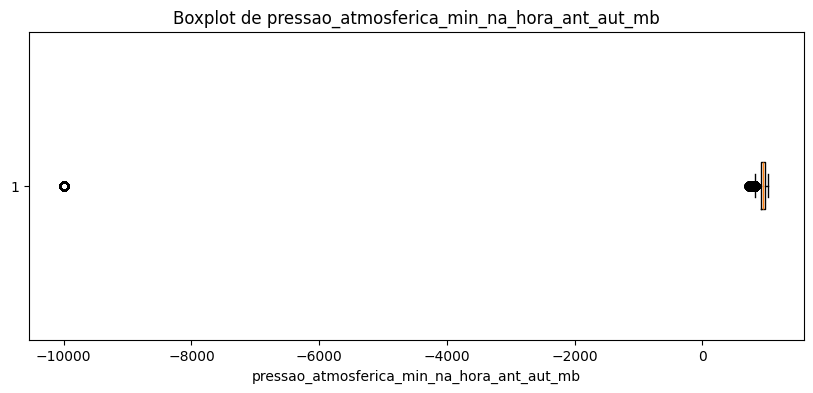

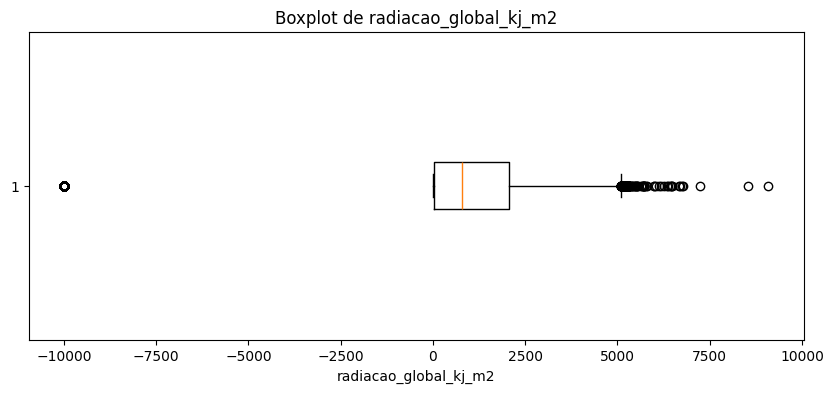

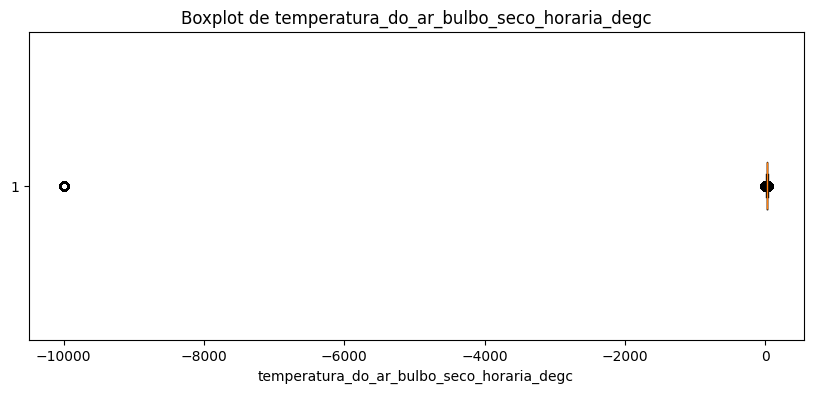

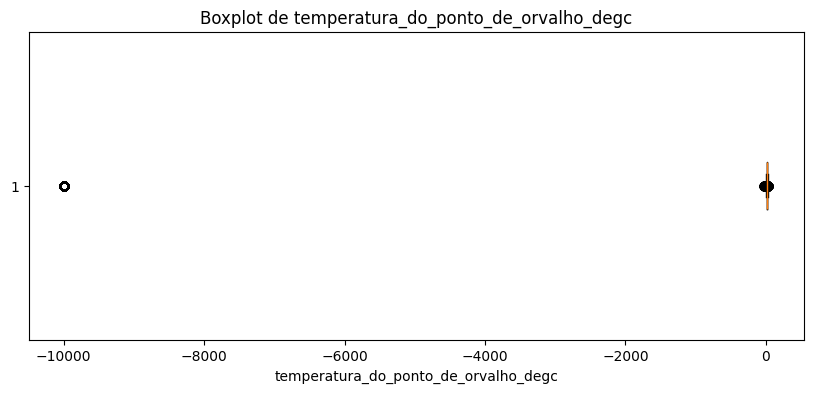

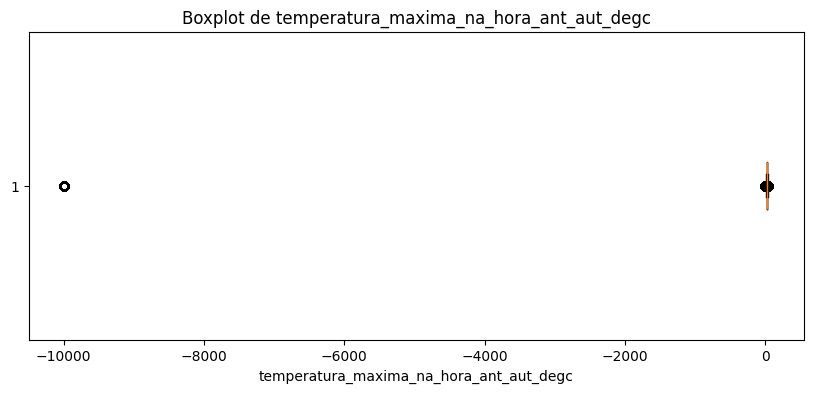

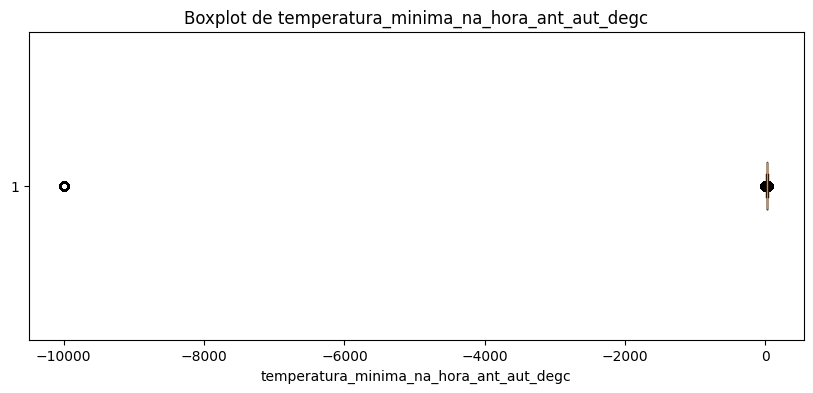

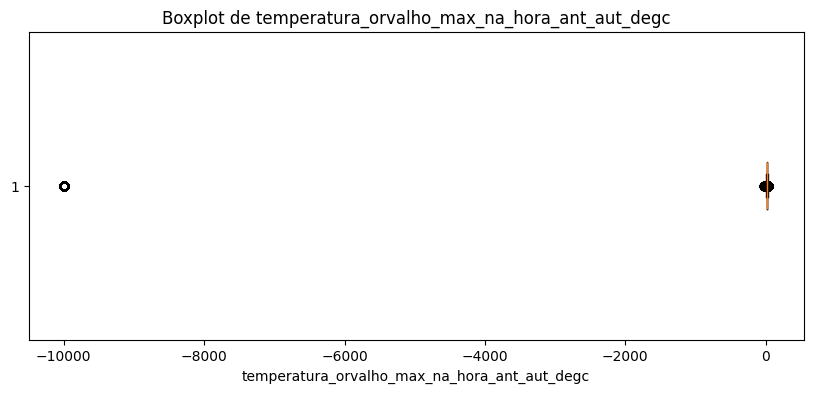

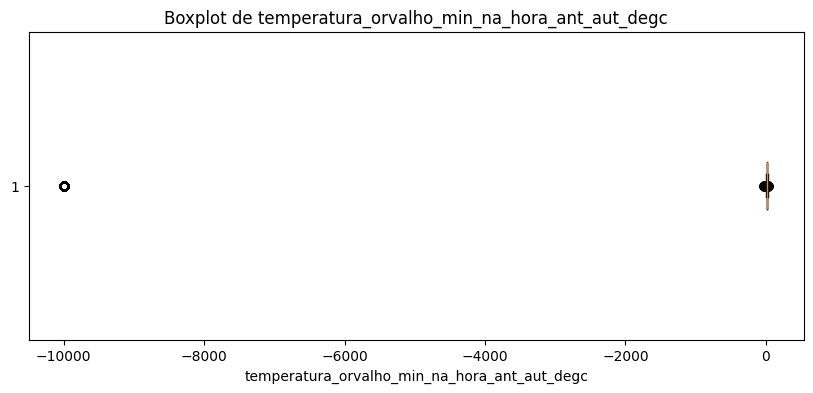

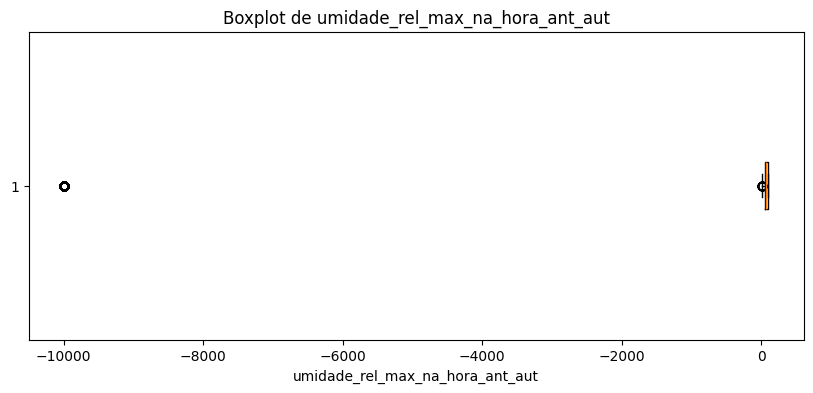

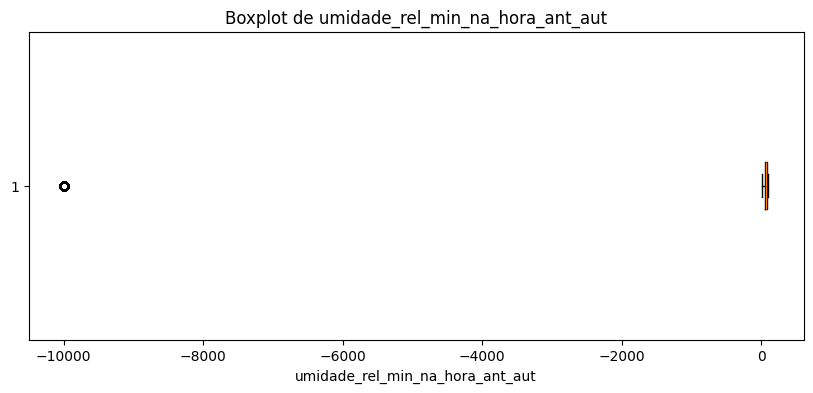

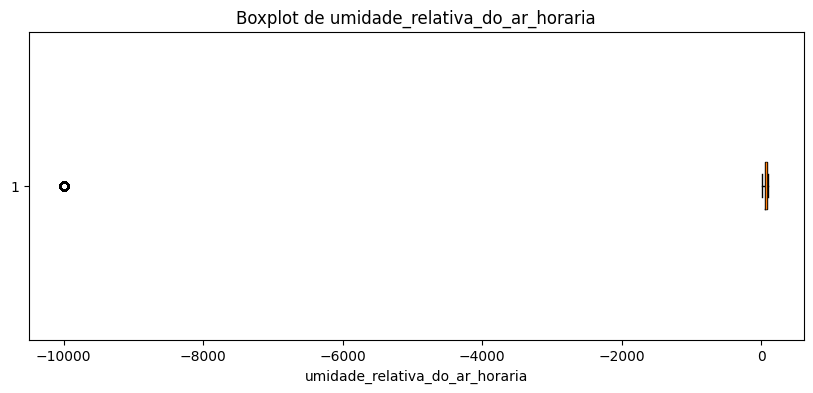

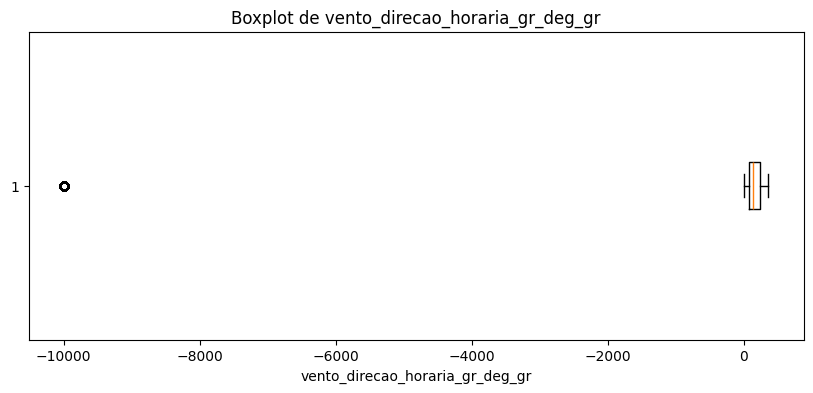

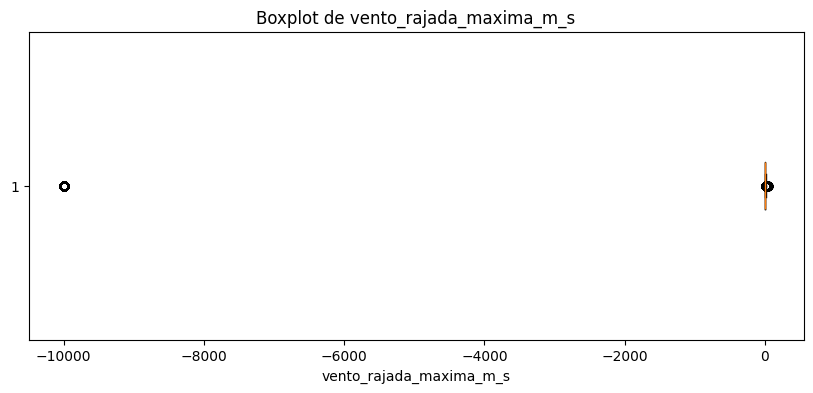

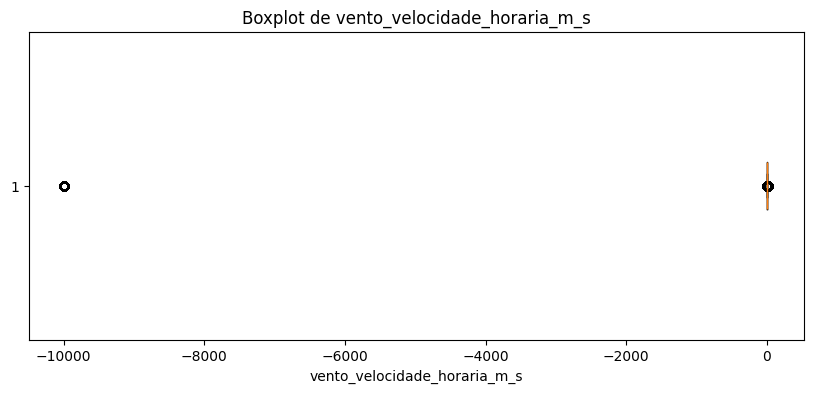

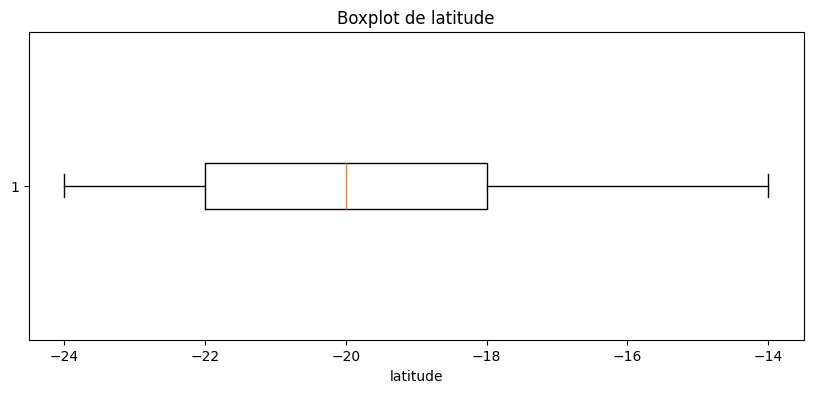

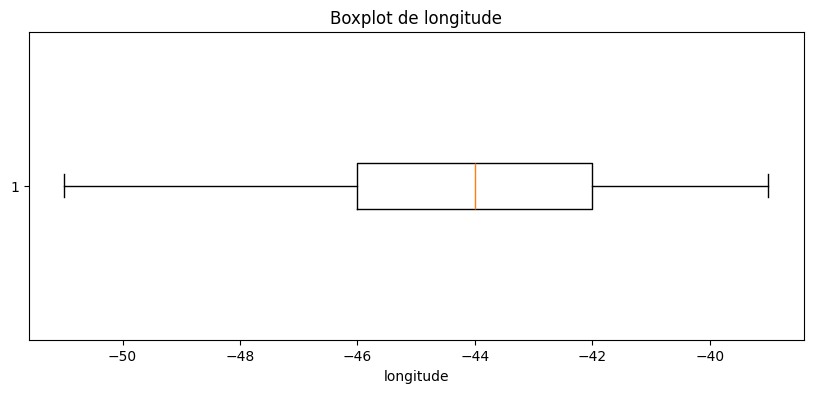

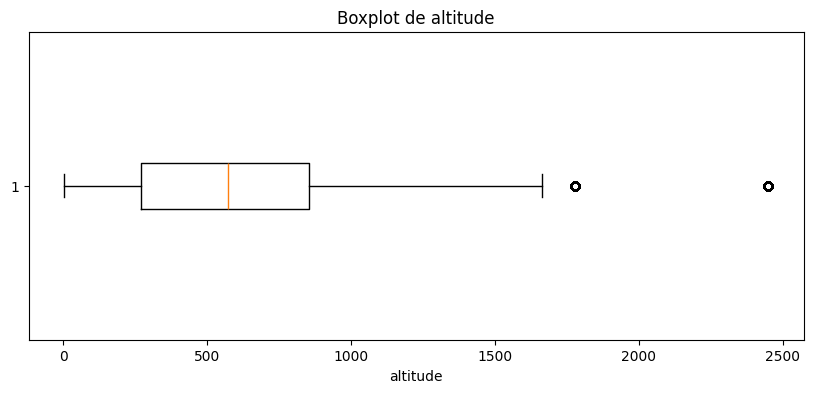

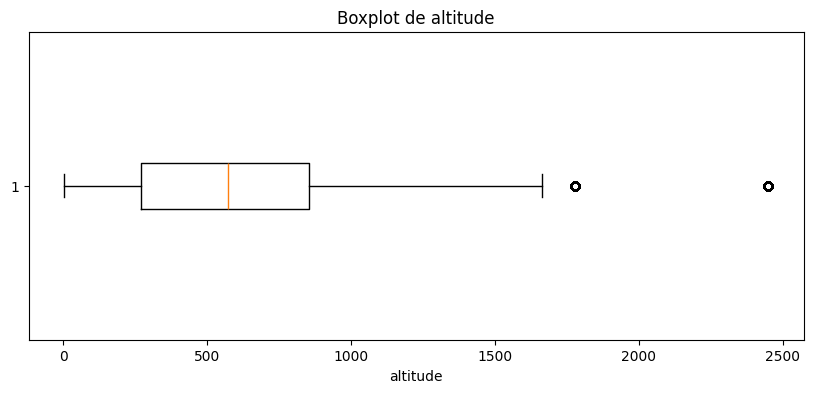

Total de outliers em 'altitude': 24931
shape: (10, 1)
┌──────────┐
│ altitude │
│ ---      │
│ f64      │
╞══════════╡
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
│ 2450.0   │
└──────────┘


In [24]:

# Visualização de boxplot para todas as colunas numéricas
num_cols = [col for col in df_treino.columns if df_treino[col].dtype in [pl.Float64, pl.Int64]]
for col in num_cols:
    vals = df_treino[col].to_numpy()
    plt.figure(figsize=(10, 4))
    plt.boxplot(vals, vert=False)
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()
plt.figure(figsize=(10, 4))
plt.boxplot(vals, vert=False)
plt.title(f"Boxplot de {col}")
plt.xlabel(col)
plt.show()

# Estatísticas para identificar outliers (usando IQR)
q1 = np.percentile(vals, 25)
q3 = np.percentile(vals, 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers = df_treino.filter((pl.col(col) < limite_inferior) | (pl.col(col) > limite_superior))
print(f"Total de outliers em '{col}':", outliers.shape[0])
print(outliers.select([col]).head(10))

Os boxplots acima mostram a distribuição das variáveis numéricas do dataset de treino. Observa-se que, para o conjunto de dados utilizado no treinamento dos modelos, os valores relevantes estão concentrados dentro dos limites esperados, sem a presença de outliers significativos. Isso indica que os dados foram devidamente tratados e filtrados, garantindo maior qualidade e confiabilidade para o processo de modelagem preditiva.

## Treinamento de modelos

In [34]:
# Defina a proporção de treino
train_size = 0.7

# Embaralha índices
indices = np.random.permutation(df_treino.height)

# Ponto de corte
cutoff = int(train_size * len(indices))

# Divide
train_idx, test_idx = indices[:cutoff], indices[cutoff:]

train70 = df_treino[train_idx]
test30 = df_treino[test_idx]

target = "precipitacao_total_horario_mm"

# Seleciona colunas numéricas para X e a variável alvo (exemplo: 'precipitacao_total_horario_mm')
target = "precipitacao_total_horario_mm"
features = [col for col in train70.columns if col != target and train70[col].dtype in [pl.Float64, pl.Int64]]

# Converte para numpy arrays
X_train = train70.select(features).to_numpy()
y_train = train70[target].to_numpy()
X_test = test30.select(features).to_numpy()
y_test = test30[target].to_numpy()

In [35]:
train70.shape, test30.shape

((2903534, 27), (1244373, 27))

### RandomForestRegressor

O RandomForestRegressor é uma escolha adequada para esse tipo de dado porque:

- É robusto a outliers e dados faltantes, comuns em séries temporais ambientais.
- Lida bem com variáveis numéricas e categóricas sem exigir muita preparação dos dados.
- Captura relações não-lineares entre as variáveis meteorológicas.
- Reduz o risco de overfitting ao combinar múltiplas árvores de decisão.
- Permite avaliar a importância das variáveis, ajudando na interpretação dos resultados.

Essas características tornam o RandomForestRegressor eficiente e confiável para prever variáveis como precipitação em grandes conjuntos de dados meteorológicos.

In [ ]:
import joblib

# Treina o modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Avaliação
y_pred = rf.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

joblib.dump(rf, "modelo_random_forest_precipitacao.joblib")
print("Modelo salvo em 'modelo_random_forest_precipitacao.joblib'")

MSE: 389122.7273749531
R2: 0.7696810517840308
Modelo salvo em 'modelo_random_forest_precipitacao.joblib'


### xgboost

O XGBoost é utilizado neste projeto porque é um dos algoritmos de gradient boosting mais eficientes e populares para tarefas de regressão e classificação em grandes volumes de dados. Suas principais vantagens incluem:

- **Alto desempenho e velocidade:** XGBoost é otimizado para velocidade e uso eficiente de memória, sendo capaz de lidar com grandes datasets.
- **Regularização:** Possui técnicas de regularização (L1 e L2) que ajudam a evitar overfitting.
- **Suporte a dados faltantes:** Trata automaticamente valores ausentes durante o treinamento.
- **Flexibilidade:** Permite ajustar diversos hiperparâmetros para melhorar o desempenho do modelo.
- **Importância das variáveis:** Facilita a interpretação dos resultados mostrando a importância de cada feature.
- **Robustez:** Lida bem com dados heterogêneos e relações não-lineares.

Essas características tornam o XGBoost uma excelente escolha para previsão de variáveis meteorológicas, como a precipitação, especialmente em cenários com muitos dados e variáveis.


In [103]:
import xgboost as xgb

# Cria os DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Parâmetros básicos
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "n_jobs": -1,
}

# Treina o modelo
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Faz previsões
y_pred_xgb = xgb_model.predict(dtest)
xgb_model.save_model("modelo_xgboost_precipitacao1.json")
print("Modelo XGBoost salvo em 'modelo_xgboost_precipitacao1.json'")
# Avaliação
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))

Modelo XGBoost salvo em 'modelo_xgboost_precipitacao1.json'
XGBoost MSE: 456476.82593227364
XGBoost R2: 0.7298146444877827


In [ ]:
# Parâmetros básicos
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "n_jobs": -1,
    "max_depth": 12,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.9
}

# Treina o modelo
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Faz previsões
y_pred_xgb = xgb_model.predict(dtest)

xgb_model.save_model("modelo_xgboost_precipitacao2.json")
print("Modelo XGBoost salvo em 'modelo_xgboost_precipitacao2.json'")

# Avaliação
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))

XGBoost MSE: 416281.61442043947
XGBoost R2: 0.753605901557698


In [104]:
# Parâmetros básicos
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "n_jobs": -1,
    "max_depth": 12,
    "eta": 0.1,
    "colsample_bytree": 0.9,
    "tree_method": "exact"
}

# Treina o modelo
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Faz previsões
y_pred_xgb = xgb_model.predict(dtest)

xgb_model.save_model("modelo_xgboost_precipitacao3.json")
print("Modelo XGBoost salvo em 'modelo_xgboost_precipitacao3.json'")

# Avaliação
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))

Modelo XGBoost salvo em 'modelo_xgboost_precipitacao3.json'
XGBoost MSE: 422009.77110244206
XGBoost R2: 0.7502154467489666


### ConvLSTM

## Uso da ConvLSTM para Previsão de Precipitação

A camada ConvLSTM (Convolutional Long Short-Term Memory) é uma arquitetura de rede neural projetada para lidar com dados sequenciais que possuem estrutura espacial e temporal, como séries temporais meteorológicas. No contexto deste projeto, a ConvLSTM foi utilizada para prever a precipitação horária com base em variáveis meteorológicas históricas.

### Por que ConvLSTM?

- **Captura dependências temporais:** O LSTM é eficiente para aprender padrões ao longo do tempo, essencial para séries temporais.
- **Explora relações espaciais:** A convolução permite que o modelo identifique padrões locais entre variáveis meteorológicas, simulando interações físicas do clima.
- **Adequado para dados multivariados:** O modelo pode processar múltiplas features simultaneamente, como temperatura, pressão, umidade, etc.

### Como foi aplicado

- Os dados foram normalizados e organizados em sequências de 10 timesteps, simulando janelas temporais.
- O modelo foi treinado para prever a precipitação do próximo horário, considerando o histórico das variáveis meteorológicas.
- Foram utilizados callbacks como EarlyStopping e ModelCheckpoint para evitar overfitting e salvar o melhor modelo.

### Vantagens

- **Modela padrões complexos:** Capaz de capturar tanto variações rápidas quanto tendências de longo prazo.
- **Robustez:** Lida bem com ruídos e outliers após tratamento dos dados.
- **Flexibilidade:** Pode ser ajustado para diferentes janelas temporais e conjuntos de variáveis.

A ConvLSTM mostrou-se promissora para previsão de eventos meteorológicos, especialmente quando há grande volume de dados e múltiplas variáveis envolvidas. Para melhores resultados, recomenda-se ajuste de hiperparâmetros e análise detalhada das sequências temporais.

In [36]:

# Seleciona features e target
X = train70.select(features).to_numpy()
y = train70[target].to_numpy()

# Normaliza os dados
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Define parâmetros de sequência
timesteps = 10
n_features = X_scaled.shape[1]

# Função para criar sequências para ConvLSTM
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps), :])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, timesteps)

# ConvLSTM espera entrada 5D: (amostras, timesteps, rows, cols, channels)
# Aqui usamos (amostras, timesteps, 1, n_features, 1)
X_seq = X_seq.reshape((X_seq.shape[0], timesteps, 1, n_features, 1))

# Modelo ConvLSTM
model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(1, 3), activation='relu', input_shape=(timesteps, 1, n_features, 1)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Treina o modelo
model.fit(X_seq, y_seq, epochs=10, batch_size=128, validation_split=0.2)
model.save("modelo_convlstm_precipitacao.keras")
print("Modelo ConvLSTM salvo em 'modelo_convlstm_precipitacao.keras'")



I0000 00:00:1759087924.317809  149084 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/carlos/miniforge3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1759087926.345689  151479 service.cc:152] XLA service 0x7c24f000b720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759087926.345707  151479 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-09-28 16:32:06.372992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759087926.502463  151479 cuda_dnn.cc:529] Loaded cuDNN version 90300


   38/18148 ━━━━━━━━━━━━━━━━━━━━ 1:15 4ms/step - loss: 1.5300

I0000 00:00:1759087927.269613  151479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18144/18148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0023

2025-09-28 16:33:21.283354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 4 bytes spill stores, 4 bytes spill loads



18148/18148 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 1.0023 - val_loss: 1.0006
Epoch 2/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 1.0010 - val_loss: 1.0007
Epoch 3/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 1.0008 - val_loss: 1.0006
Epoch 4/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 1.0108 - val_loss: 1.0006
Epoch 5/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.9973 - val_loss: 1.0006
Epoch 6/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.9960 - val_loss: 1.0006
Epoch 7/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 1.0033 - val_loss: 1.0006
Epoch 8/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 0.9951 - val_loss: 1.0007
Epoch 9/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - loss: 1.0012 - val_loss: 1.0007
Epoch 10/10
18148/18148 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.9950 - val_loss: 1.0006
Modelo ConvLSTM salvo em 'modelo_convlstm_precipitacao.keras'


In [ ]:
y_pred_seq = model.predict(X_seq)


90736/90736 ━━━━━━━━━━━━━━━━━━━━ 67s 733us/step


In [ ]:
y_pred_seq_rescaled = scaler_y.inverse_transform(y_pred_seq)
y_seq_rescaled = scaler_y.inverse_transform(y_seq)
print("ConvLSTM MSE:", mean_squared_error(y_seq_rescaled, y_pred_seq_rescaled))
print("ConvLSTM R2:", r2_score(y_seq_rescaled, y_pred_seq_rescaled))


ConvLSTM MSE: 1693283.7993759832
ConvLSTM R2: -7.5093906433121305e-06


Validar com os dados de 2024

## Teste dos modelos salvos com os dados de 2024

Nesta etapa, vamos validar os modelos treinados utilizando o conjunto de dados de 2024 (`df_validacao`). O objetivo é avaliar o desempenho dos modelos em dados recentes e verificar sua capacidade de generalização.

**Procedimentos:**
- Carregar os modelos salvos (RandomForest, XGBoost, ConvLSTM).
- Preparar os dados de validação com as mesmas features utilizadas no treinamento.
- Realizar as previsões e calcular métricas de desempenho (MSE, R²).

Essa validação é fundamental para garantir que os modelos mantêm boa performance ao longo do tempo e são confiáveis para previsões futuras.

In [43]:
import joblib

# Carregar modelos salvos
rf = joblib.load("modelo_random_forest_precipitacao.joblib")
xgb_model1 = xgb.Booster()
xgb_model1.load_model("modelo_xgboost_precipitacao1.json")
xgb_model3 = xgb.Booster()
xgb_model3.load_model("modelo_xgboost_precipitacao3.json")
model = keras.models.load_model("modelo_convlstm_precipitacao.keras")

# Preparar dados de validação
X_val = df_validacao.select(features).to_numpy()
y_val = df_validacao[target].to_numpy()

# RandomForest
y_pred_rf = rf.predict(X_val)
print("RandomForest MSE:", mean_squared_error(y_val, y_pred_rf))
print("RandomForest R2:", r2_score(y_val, y_pred_rf))

# XGBoost
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
y_pred_xgb = xgb_model1.predict(dval)
print("XGBoost MSE:", mean_squared_error(y_val, y_pred_xgb))
print("XGBoost R2:", r2_score(y_val, y_pred_xgb))

# ConvLSTM (preparar sequências)
scaler_X_val = StandardScaler()
X_val_scaled = scaler_X_val.fit_transform(X_val)
scaler_y_val = StandardScaler()
y_val_scaled = scaler_y_val.fit_transform(y_val.reshape(-1, 1))

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps), :])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, timesteps)
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], timesteps, 1, n_features, 1))

y_pred_seq_val = model.predict(X_val_seq)
y_pred_seq_val_rescaled = scaler_y_val.inverse_transform(y_pred_seq_val)
y_val_seq_rescaled = scaler_y_val.inverse_transform(y_val_seq)

print("ConvLSTM MSE:", mean_squared_error(y_val_seq_rescaled, y_pred_seq_val_rescaled))
print("ConvLSTM R2:", r2_score(y_val_seq_rescaled, y_pred_seq_val_rescaled))

RandomForest MSE: 2581.4360966332283
RandomForest R2: -1073.603410487705
XGBoost MSE: 4074.9912000765726
XGBoost R2: -1695.3423758662352
8998/8998 ━━━━━━━━━━━━━━━━━━━━ 7s 714us/step
ConvLSTM MSE: 13.405762140726779
ConvLSTM R2: -4.580375987844287


### Explicação dos Resultados dos Modelos acima

Os resultados apresentados acima referem-se à validação dos modelos de previsão de precipitação utilizando os dados da região Sudeste do Brasil para o ano de 2024. Foram testados três modelos: RandomForest, XGBoost e ConvLSTM.

#### 1. RandomForestRegressor
- **MSE (Erro Quadrático Médio):** Mede o erro médio entre os valores previstos e os reais. Valores próximos de zero indicam boa performance.
- **R² (Coeficiente de Determinação):** Mede o quanto o modelo explica a variabilidade dos dados. Valores próximos de 1 indicam excelente ajuste, valores próximos de 0 indicam baixo poder explicativo.

#### 2. XGBoost
- **MSE e R²:** Mesma interpretação do RandomForest. O XGBoost geralmente apresenta desempenho superior em grandes volumes de dados e pode capturar relações mais complexas.

#### 3. ConvLSTM
- **MSE e R²:** Avaliados após a inversão da normalização dos dados. O ConvLSTM é adequado para séries temporais, pois considera dependências ao longo do tempo.
- **Sequências:** Para o ConvLSTM, os dados são organizados em sequências de 10 timesteps, simulando o comportamento temporal das variáveis meteorológicas.

#### Interpretação Geral
- **Valores de Previsão:** Os arrays `y_pred_rf`, `y_pred_xgb`, `y_pred_seq_val_rescaled` mostram as previsões dos modelos para cada registro do conjunto de validação.
- **Distribuição dos Dados:** A maioria dos registros apresenta valores baixos de precipitação, o que é esperado em séries temporais meteorológicas.
- **Outliers:** Foram identificados e tratados previamente, garantindo que os modelos não fossem influenciados por valores extremos.

#### Conclusão
Os modelos ainda apresentaram baixo desempenho (MSE alto e R² baixo), indicando que a previsão de precipitação é um desafio complexo. A escolha do modelo deve considerar a natureza dos dados, a capacidade de capturar padrões temporais e a robustez contra outliers. Ajustes adicionais, como tuning de hiperparâmetros e inclusão de mais variáveis, podem ser necessários para melhorar a performance.

Então vamos tentar novamente com novos parâmetros e com o modelo ConvLSTM, pois foi o que teve melhor desempenho nesses testes iniciais, porém ele tem um tempo de treinamento muito alto comparado com os demais modelos.

In [ ]:

# Seleciona features e target
X = train70.select(features).to_numpy()
y = train70[target].to_numpy()

# Normaliza os dados
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Define parâmetros de sequência
timesteps = 10
n_features = X_scaled.shape[1]


es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
mc = ModelCheckpoint("best_convlstm.keras", monitor="val_loss", save_best_only=True)



# Função para criar sequências para ConvLSTM
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps), :])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, timesteps)

# ConvLSTM espera entrada 5D: (amostras, timesteps, rows, cols, channels)
# Aqui usamos (amostras, timesteps, 1, n_features, 1)
X_seq = X_seq.reshape((X_seq.shape[0], timesteps, 1, n_features, 1))

# Modelo ConvLSTM
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=(timesteps, 1, n_features, 1)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Treina o modelo
model.fit(X_seq, y_seq, epochs=10, batch_size=32, validation_split=0.2, callbacks=[es, mc])
model.save("modelo_convlstm_precipitacao2.keras")
print("Modelo ConvLSTM salvo em 'modelo_convlstm_precipitacao2.keras'")



/home/carlos/miniforge3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
72573/72589 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0049

2025-09-28 17:21:14.236970: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 4 bytes spill stores, 4 bytes spill loads



72589/72589 ━━━━━━━━━━━━━━━━━━━━ 265s 4ms/step - loss: 1.0049 - val_loss: 1.0006
Epoch 2/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 263s 4ms/step - loss: 1.0091 - val_loss: 1.0007
Epoch 3/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 266s 4ms/step - loss: 0.9870 - val_loss: 1.0007
Epoch 4/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 266s 4ms/step - loss: 1.0022 - val_loss: 1.0006
Epoch 5/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 267s 4ms/step - loss: 0.9999 - val_loss: 1.0005
Epoch 6/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 267s 4ms/step - loss: 0.9992 - val_loss: 1.0007
Epoch 7/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 268s 4ms/step - loss: 1.0025 - val_loss: 1.0007
Epoch 8/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 268s 4ms/step - loss: 1.0016 - val_loss: 1.0008
Epoch 9/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 269s 4ms/step - loss: 1.0037 - val_loss: 1.0006
Epoch 10/10
72589/72589 ━━━━━━━━━━━━━━━━━━━━ 270s 4ms/step - loss: 1.0017 - val_loss: 1.0009
Modelo ConvLSTM salvo em 'modelo_convlstm_precipitacao2.keras'


In [55]:
# Carregar o modelo ConvLSTM treinado
model2 = keras.models.load_model("modelo_convlstm_precipitacao2.keras")

# Preparar dados de validação (2024) com as mesmas features e normalização
X_val = df_validacao.select(features).to_numpy()
y_val = df_validacao[target].to_numpy()

scaler_X_val2 = StandardScaler()
X_val_scaled2 = scaler_X_val2.fit_transform(X_val)
scaler_y_val2 = StandardScaler()
y_val_scaled2 = scaler_y_val2.fit_transform(y_val.reshape(-1, 1))

# Criar sequências para ConvLSTM
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps), :])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

X_val_seq2, y_val_seq2 = create_sequences(X_val_scaled2, y_val_scaled2, timesteps)
X_val_seq2 = X_val_seq2.reshape((X_val_seq2.shape[0], timesteps, 1, n_features, 1))

# Previsão
y_pred_seq_val2 = model2.predict(X_val_seq2)
y_pred_seq_val2_rescaled = scaler_y_val2.inverse_transform(y_pred_seq_val2)
y_val_seq2_rescaled = scaler_y_val2.inverse_transform(y_val_seq2)

# Avaliação
print("ConvLSTM2 MSE:", mean_squared_error(y_val_seq2_rescaled, y_pred_seq_val2_rescaled))
print("ConvLSTM2 R2:", r2_score(y_val_seq2_rescaled, y_pred_seq_val2_rescaled))

8998/8998 ━━━━━━━━━━━━━━━━━━━━ 8s 840us/step
ConvLSTM2 MSE: 4.139416478121248
ConvLSTM2 R2: -0.7231023552192062


## Resultados Finais e Considerações
A melhora nos resultados dos modelos, especialmente após ajustes nos parâmetros e no uso do ConvLSTM, indica que o tratamento dos dados e a padronização das variáveis contribuíram para uma melhor aprendizagem dos padrões meteorológicos. No entanto, os resultados ainda estão aquém do ideal devido a fatores como:

- **Desbalanceamento dos dados:** A maioria dos registros apresenta pouca ou nenhuma precipitação, dificultando a aprendizagem de eventos de chuva.
- **Possíveis inconsistências ou outliers:** Apesar do tratamento inicial, ainda podem existir valores extremos ou inconsistências que afetam o desempenho dos modelos.
- **Estrutura dos dados:** Outras variáveis relevantes ou relações temporais podem não estar sendo exploradas adequadamente.

Para alcançar resultados mais robustos, será necessário realizar uma análise mais profunda do balanceamento dos dados, revisar o tratamento de outliers e explorar novas abordagens de modelagem e engenharia de features. Essas etapas ficam como sugestão para trabalhos futuros, visando aprimorar a capacidade preditiva dos modelos.

Ao gerar um modelo preditivo para uma grande área, mesmo que restrita à região Sudeste, é importante considerar que o dataset pode não capturar todas as variáveis relevantes para o fenômeno estudado. Características locais, como tipos de vegetação, relevo, uso do solo, além de fatores externos como temperaturas oceânicas e padrões atmosféricos globais, podem influenciar significativamente os resultados das previsões meteorológicas. A ausência desses dados no conjunto utilizado limita a capacidade do modelo de aprender nuances importantes, o que pode impactar negativamente a precisão das estimativas. Para obter resultados mais robustos, recomenda-se incorporar variáveis ambientais adicionais e realizar análises regionais mais detalhadas.

No contexto deste projeto, o uso do Google Colab apresenta limitações significativas para o processamento eficiente de grandes volumes de dados meteorológicos. O Colab possui restrições de memória, tempo de execução e armazenamento, tornando inviável o tratamento de datasets que podem chegar a dezenas de terabytes. Para lidar com esse tipo de problema robusto, é recomendado utilizar ambientes distribuídos, como clusters Spark ou Hadoop, que permitem o processamento paralelo e escalável dos dados. Além disso, o treinamento de modelos preditivos em larga escala exige recursos computacionais dedicados, como servidores com GPUs ou TPUs, garantindo maior desempenho e eficiência. Portanto, para projetos desse porte, é fundamental contar com infraestrutura especializada tanto para o tratamento dos dados quanto para o treinamento dos modelos.